# Unary-to-Unary-to-Unary Autoencoder

The goal of this experiment is to make an autoencoder which given a unary input should produce the same unary output. Typically, this is a nonissue but we complicate the task by having a binary intermediate layer. This turn out to be somewhat non trivial.

In [1]:
%matplotlib inline

import os
# Changing requires kernel restart
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=opencl0:0,floatX=float32"
import pathfix
from stdinc import *
from keras.regularizers import l1, l2, activity_l1, activity_l2

Using Theano backend.


## Problem Data

In [2]:
trial_range = range(1,9)

trials = []
for i in trial_range:
    lst = np.asarray([int(i == j) for j in trial_range]).astype('int')
    trials.append(AttrDict({
        "input": lst,
        "target": lst
    }))
trials = np.asarray(trials)

print('% i data sequences' % len(trials))

 8 data sequences


## Parameters

In [24]:
nb_epoch = 1
nb_feedbacks = 10
batch_size = 1
min_epoch_size = int(batch_size*divf(nb_feedbacks, nb_epoch))
print("Batch size: %i" % batch_size)
print("Min epoch size: %i" % min_epoch_size)

Batch size: 1
Min epoch size: 10


## Data Sets

In [25]:
epoch_trials = np.tile(trials, int(math.ceil(divf(min_epoch_size, len(trials)))))
np.random.shuffle(epoch_trials)

data_train = np.array([x.input for x in epoch_trials])
labels_train = data_train
data_test = data_train
labels_test = data_test

data_shape = data_train[0].shape
labels_shape = labels_train[0].shape

## Model Definition

In [26]:
print('Building model...')

def binary_activation(x):
    return K.round(x)

params = {
    "init":'he_normal',
    #"W_regularizer":l1(0.001),
    #"activity_regularizer":activity_l1(0.1)
}
srelu = SReLU(a_left_init='he_uniform', t_right_init='he_uniform')
prelu = PReLU()
threlu = ThresholdedReLU()
l_input = Input(shape=data_shape)

model = Sequential([
    Dense(8, name='dense1', input_shape=data_shape, **params),
    #Dense(labels_shape[0], input_shape=data_shape),
    #Dropout(0.5),
    Activation('sigmoid', name='dense1_activation'),
    Activation(GaussianDropout(0.01), name='dense1_gdropout'),
    Activation(lambda x: 10000 * x, name='dense1_scale10000'),
    Activation('softmax', name='dense1_softmax'),
    #BatchNormalization(),
    #Activation(binary_activation),
    Dense(6*labels_shape[0], name='dense2', **params),
    Dropout(0.5, name='dense2_dropout'),
    Activation(srelu, name='dense2_activation'),
    #Activation(prelu),
    #BatchNormalization(),
    Dense(2*labels_shape[0], name='dense3', **params),
    #Dropout(0.5),
    Activation('sigmoid', name='dense3_activation'),
    #BatchNormalization(),
    Dense(labels_shape[0], name='dense4', **params),
    Activation('softmax', name='dense4_softmax'),
])
adam_optimizer = Adam(lr=0.1)#1.0/math.sqrt(nb_feedbacks*1.0))
model.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy',
    #loss='mse',
    optimizer=adam_optimizer,
    metrics=['accuracy'],
)
print(model.summary())

Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense1 (Dense)                   (None, 8)             72          dense_input_5[0][0]              
____________________________________________________________________________________________________
dense1_activation (Activation)   (None, 8)             0           dense1[0][0]                     
____________________________________________________________________________________________________
dense1_gdropout (Activation)     (None, 8)             0           dense1_activation[0][0]          
____________________________________________________________________________________________________
dense1_scale10000 (Activation)   (None, 8)             0           dense1_gdropout[0][0]            
_________________________________________________________________________

## Training

In [54]:
early_stopping = EarlyStopping(monitor='loss', patience=3)
import time
t0 = time.time()
fit_history = model.fit(
    data_train, labels_train,
    nb_epoch=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping]
)
print("Training time: %.2fs" % (time.time() - t0))
score = model.evaluate(
    data_test, labels_test,
    batch_size=batch_size,
    verbose=0,
)

#print(fit_history.history)
print('')
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Epoch 1/1
16/16 [==============================] - 0s - loss: 0.2820 - acc: 0.3750     
Training time: 0.01s

Test loss: 0.263
Test accuracy: 0.375


## Model Inspection

In [16]:
# #TODO: add on_unused_input='ignore'
# print("Transformations")
# for trial in trials:
#     data = [trial.input]
#     print('')
#     print("Input")
#     print(numpy_to_list(data[0]))
#     for i, layer in enumerate(model.layers):
#         print("Layer %i: %s" % (i, layer.__class__.__name__))
#         layer_f = K.function(
#             [model.layers[0].input, K.learning_phase()],
#             [model.layers[i].output]
#         )
#         print(np.asarray(layer_f([data, 1])[0][0]))
#     #break

# print('')
# print("Parameters")
# for i, layer in enumerate(model.layers):
#     print(layer.__class__.__name__)
#     print(layer.get_config())

print('')
print("All cases")
for trial in trials:
    print(trial.input)
    print(model.predict(np.array([trial.input]))[0])


All cases
[1 0 0 0 0 0 0 0]
[+0.217 +0.297 +0.253 +0.001 +0.001 +0.001 +0.233 +0.001]
[0 1 0 0 0 0 0 0]
[+0.217 +0.297 +0.253 +0.001 +0.001 +0.001 +0.233 +0.001]
[0 0 1 0 0 0 0 0]
[+0.217 +0.297 +0.253 +0.001 +0.001 +0.001 +0.233 +0.001]
[0 0 0 1 0 0 0 0]
[+0.001 +0.001 +0.001 +0.539 +0.001 +0.001 +0.001 +0.461]
[0 0 0 0 1 0 0 0]
[+0.001 +0.001 +0.001 +0.001 +1.000 +0.001 +0.001 +0.001]
[0 0 0 0 0 1 0 0]
[+0.001 +0.001 +0.001 +0.001 +0.001 +1.000 +0.001 +0.001]
[0 0 0 0 0 0 1 0]
[+0.217 +0.297 +0.253 +0.001 +0.001 +0.001 +0.233 +0.001]
[0 0 0 0 0 0 0 1]
[+0.001 +0.001 +0.001 +0.539 +0.001 +0.001 +0.001 +0.461]


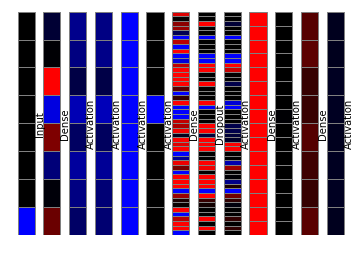

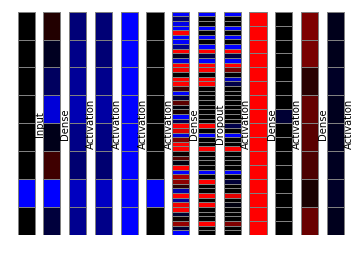

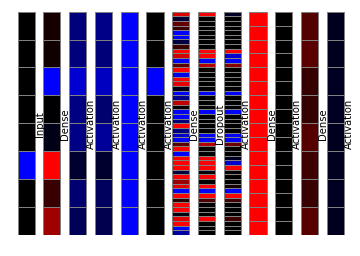

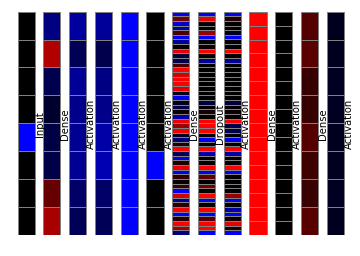

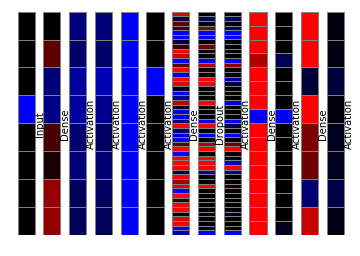

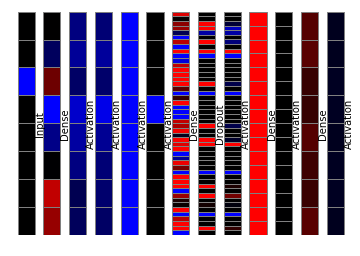

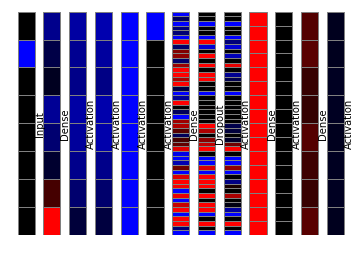

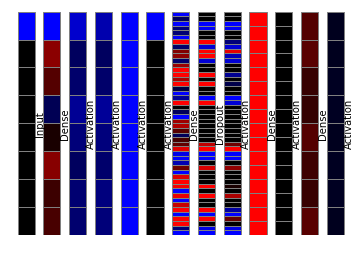

In [38]:
figs = []
figs=visualize_layer_activations(model, figs=figs)


In [56]:
figs=visualize_layer_activations(model, figs=figs)

In [37]:
def add_array_to_plot(ax,a,x=0,y=0,w=1,h=1,maxval=1.0):
    edge_color = '0.5'
    for val in a:
        sval = min(1.0, divf(abs(val), maxval))
        colr = ()
        if val >= 0:
            colr = (0.0, 0.0, sval)
        else:
            colr = (sval, 0.0, 0.0)
        ax.add_patch(
            patches.Rectangle(
                (x, y), # (x,y)
                w, # width
                divf(h, len(a)), # height,
                facecolor=colr,
                edgecolor=edge_color
            )
        )
        y += divf(h, len(a))
    return w,h

def visualize_arrays(ars, labels=['a', 'b'], fig=None):
    if fig is None:
        fig = plt.figure()
    ax = fig.add_subplot(111)
    w, h = 0, 0
    lh = 0
    for i, a in enumerate(ars):
        aw, ah = add_array_to_plot(ax, a, x=w, y=h, w=1, h=8)
        if i < len(labels):
            ax.text(
                w+aw, h+0.5*ah, labels[i],
                #horizontalalignment='center',
                #verticalalignment='center',
                va='center',
                ha='left',
                rotation='vertical',
                #transform=ax.transAxes
            )
        w += aw + 0.5
        lh = max(lh, ah)
    h += lh
    ax.axis('off')
    ax.set_xlim(0,w)
    ax.set_ylim(0,h)
    return fig

model_layer_f_cache = {}
def visualize_layer_activations(model, figs=[]):
    #TODO: add on_unused_input='ignore'
    for trial_i, trial in enumerate(trials):
        layer_data = []
        layer_texts = []
        data = [trial.input]
        layer_data.append(np.asarray(data[0]))
        layer_texts.append('Input')
        for i, layer in enumerate(model.layers):
            if model not in model_layer_f_cache:
                model_layer_f_cache[model] = []
            if i >= len(model_layer_f_cache[model]):
                listset(
                    model_layer_f_cache[model],
                    i,
                    K.function(
                        [model.layers[i].input, K.learning_phase()],
                        [model.layers[i].output]
                    )
                )
            layer_f = model_layer_f_cache[model][i]
            data = np.asarray(layer_f([data, 1])[0])
            layer_data.append(data[0])
            layer_texts.append(layer.__class__.__name__)
        fig = figs[trial_i] if trial_i < len(figs) else None
        fig = visualize_arrays(layer_data, layer_texts, fig=fig)
        listset(figs, trial_i, fig)
        plt.show()
    return figs
#visualize_arrays([[0.5, 0.1], [-1.0, 1.0]])


In [9]:
#print model.layers[-2].get_output()